# Neural Network Kaggle Exercise (Core)
- Student: Michael McCann
- Date: 06 APR 2022

# Setup

## Mount Drive

In [1]:
## Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import set_config
set_config(display='diagram')


## Load Data

In [3]:
# Datapaths
train_path = '/content/drive/MyDrive/Data/kaggle/kaggle_housing_train.csv'
test_path = '/content/drive/MyDrive/Data/kaggle/kaggle_housing_test.csv'

## Mapping Function

In [4]:
# Create function to graph results of Neural Network
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

# Training Dataset

In [5]:
# Load Training Data
train = pd.read_csv(train_path)

In [6]:
#Inspect the data
display(train.head())
print('\n\n')
train.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  Overa

## Setup

### Ordinal Encoding and NA replacement

In [7]:
# According to the Ames documentation a large number of the columns are meant to 
# be ordinal. The NA's in these columns are menat to represent No feature (basement, 
# fireplace, driveway, etc)

# Define Ordinal Columns
ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'LotShape',
             'LandSlope', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
             'Functional', 'GarageFinish', 'PavedDrive', 'Fence', 'BsmtExposure']

# Define Ordinal Map
ord_map = {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4, #Lot shape
           'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, #Pool, Garage, Kitchen, Fireplace, Exterior, Basement Quality
           'No':1, 'Mn':2, 'Av':3, # Basement Condition and Exposuer
           'Sev':1, 'Mod':2, 'Gtl':3, #Slope
           'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ':4, 'ALQ':5, 'GLQ':6, #Basement Finish
           'N':0, 'P':1, 'Y':2, # Paved Drive
           'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5, #Electrical
           'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7, #Functionality
           'Unf':1, 'RFn':2, 'Fin':3, #Garage Finish
           'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4 #Fence Qual
           }

# Create Function to apply map to columns
for col in ord_cols:
    train[col] = train[col].map(ord_map)
    train[col].fillna(value = 0, inplace = True)
    train[col] = train[col].astype(int)

train['CentralAir'] = train['CentralAir'].map({'N':0, 'Y':1})

# Fix NA's based on documentation
na_list = ['Alley', 'MiscFeature', 'GarageType']

for col in na_list:
    train[col].fillna(value = f'no {col}', inplace = True)

### Make Transformers

In [8]:
## Instantiate Preprocessing Functions/transformers
# Make Selectors
num_sel = make_column_selector(dtype_include = 'number')
cat_sel = make_column_selector(dtype_include = 'object')

# Instantiate Transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
mean_imputer = SimpleImputer(strategy = "mean")
freq_imputer = SimpleImputer(strategy = "most_frequent")

In [9]:
# Make Pipeline
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

In [10]:
# Create processor
from sklearn.decomposition import PCA

transformer = make_column_transformer((num_pipe, num_sel),
                                    (cat_pipe, cat_sel),
                                    remainder = 'passthrough')

processor = make_pipeline(transformer, PCA(n_components=.95))
processor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd540183ad0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd540183a90>)])),
                ('pca', PCA(n_components=0.95))])

## Attempt 1: Neural Network with PCA 

In [11]:
# Train Test Split
X = train.drop(columns = 'SalePrice')
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 53)

In [12]:
# Fit to the Processor
X_train = processor.fit_transform(X_train)
X_test = processor.transform(X_test)

In [13]:
input_shape = X_train.shape[1]
input_shape

60

Epoch 1/275
35/35 [==============================] - 4s 35ms/step - loss: 38513307648.0000 - mse: 38513307648.0000 - val_loss: 40606351360.0000 - val_mse: 40606351360.0000
Epoch 2/275
35/35 [==============================] - 0s 6ms/step - loss: 38497918976.0000 - mse: 38497918976.0000 - val_loss: 40567980032.0000 - val_mse: 40567980032.0000
Epoch 3/275
35/35 [==============================] - 0s 8ms/step - loss: 38414761984.0000 - mse: 38414761984.0000 - val_loss: 40398090240.0000 - val_mse: 40398090240.0000
Epoch 4/275
35/35 [==============================] - 0s 3ms/step - loss: 38116536320.0000 - mse: 38116536320.0000 - val_loss: 39877918720.0000 - val_mse: 39877918720.0000
Epoch 5/275
35/35 [==============================] - 0s 3ms/step - loss: 37343272960.0000 - mse: 37343272960.0000 - val_loss: 38689599488.0000 - val_mse: 38689599488.0000
Epoch 6/275
35/35 [==============================] - 0s 3ms/step - loss: 35717279744.0000 - mse: 35717279744.0000 - val_loss: 36417458176.0000 -

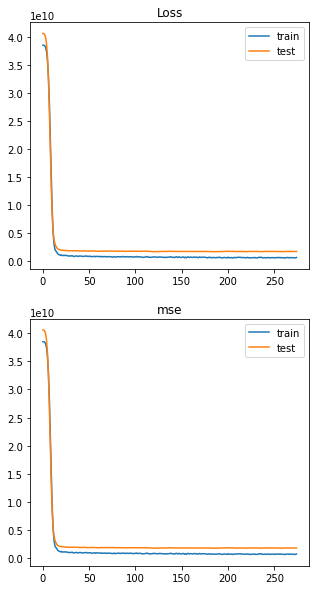

None

Training rmse: 17359.192
Testing rmse: 41913.998

Training R2: 0.948
Test R2: 0.773


In [14]:
# # Overfit model without dropout
model = Sequential()

# First Hidden Layer
model.add(Dense(60,
          input_dim = input_shape,
          activation = 'relu')) 
model.add(Dropout(.1)) 
          
# Second Hidden Layer
model.add(Dense(60, 
          activation = 'relu'))
model.add(Dropout(.1)) 

# Third Hidden Layer
model.add(Dense(60, 
          activation = 'relu'))
model.add(Dropout(.1)) 

# Output Layer
model.add(Dense(1,
                activation = 'relu'))

# Compile the model
model.compile(optimizer = 'adam', loss = 'mse', metrics = 'mse')

# early_stopping = EarlyStopping(patience = 5)

# Fit the model
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=275) #, callbacks = [early_stopping])
                    
# Neural Network Plot
display(plot_history(history, 'mse'))

# Evaluation Metrics
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print(f'Training rmse: {np.sqrt(mean_squared_error(y_train, train_preds)):.3f}')
print(f'Testing rmse: {np.sqrt(mean_squared_error(y_test, test_preds)):.3f}')

print(f'\nTraining R2: {r2_score(y_train, train_preds):.3f}')
print(f'Test R2: {r2_score(y_test, test_preds):.3f}')

### Results
After multiple iterations this iteration of our neural network appears to do best with 3 layers each with ~60 neurons/nodes. Multiple tests show that netween 250 and 300 epocs the model starts to go backwards...

- Top Training RMSE: ~40k
- Top R2: ~ 0.79

## Attempt 2: with Feature Selection

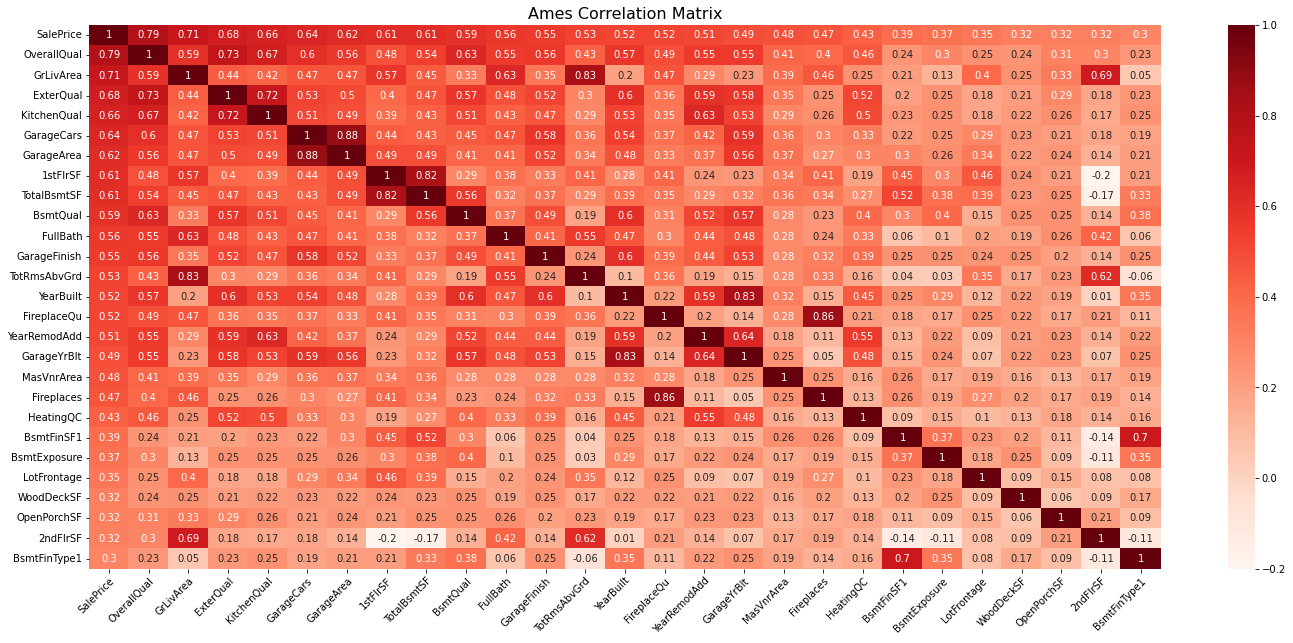

In [15]:
## Establish correlation
corr = round(train.drop(columns = ['Id']).corr(), 2)
select = list(corr[(corr['SalePrice'] >= .3) | (corr['SalePrice'] <= -.3)]['SalePrice'].sort_values(ascending = False).index)

train_select = train[select]

corr = round(train_select.corr(), 2)

# Plot correlation matrix
fig, ax = plt.subplots(figsize= (24,10))
sns.heatmap(corr, cmap = 'Reds', annot = True, ax = ax)
plt.title('Ames Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

In [16]:
# Train Test Split
X = train_select.drop(columns = 'SalePrice')
y = train_select['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 53)

In [17]:
# Fit to the Processor
X_train = processor.fit_transform(X_train)
X_test = processor.transform(X_test)

In [18]:
input_shape = X_train.shape[1]
input_shape

18

Epoch 1/275
35/35 [==============================] - 1s 7ms/step - loss: 38515027968.0000 - mse: 38515027968.0000 - val_loss: 40611586048.0000 - val_mse: 40611586048.0000
Epoch 2/275
35/35 [==============================] - 0s 3ms/step - loss: 38514503680.0000 - mse: 38514503680.0000 - val_loss: 40610705408.0000 - val_mse: 40610705408.0000
Epoch 3/275
35/35 [==============================] - 0s 3ms/step - loss: 38512861184.0000 - mse: 38512861184.0000 - val_loss: 40607694848.0000 - val_mse: 40607694848.0000
Epoch 4/275
35/35 [==============================] - 0s 3ms/step - loss: 38507405312.0000 - mse: 38507405312.0000 - val_loss: 40598319104.0000 - val_mse: 40598319104.0000
Epoch 5/275
35/35 [==============================] - 0s 3ms/step - loss: 38492098560.0000 - mse: 38492098560.0000 - val_loss: 40574611456.0000 - val_mse: 40574611456.0000
Epoch 6/275
35/35 [==============================] - 0s 3ms/step - loss: 38456705024.0000 - mse: 38456705024.0000 - val_loss: 40525078528.0000 - 

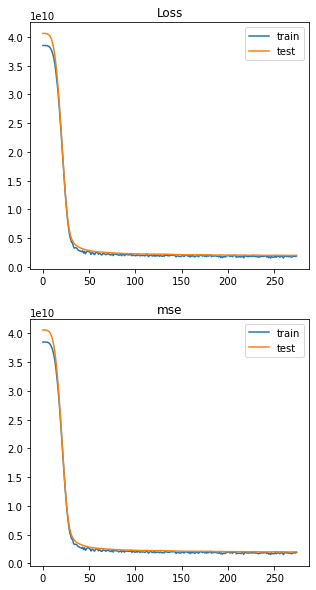

None

Training rmse: 28865.411
Testing rmse: 45116.007

Training R2: 0.857
Test R2: 0.737


In [19]:
# # Overfit model without dropout
model2 = Sequential()

# First Hidden Layer
model2.add(Dense(20,
          input_dim = input_shape,
          activation = 'relu')) 
model2.add(Dropout(.1)) 
          
# Second Hidden Layer
model2.add(Dense(20, 
          activation = 'relu'))
model2.add(Dropout(.1)) 

# Third Hidden Layer
model2.add(Dense(20, 
          activation = 'relu'))
model2.add(Dropout(.1)) 

# Output Layer
model2.add(Dense(1,
                activation = 'relu'))

# Compile the model
model2.compile(optimizer = 'adam', loss = 'mse', metrics = 'mse')

# early_stopping = EarlyStopping(patience = 5)

# Fit the model
history = model2.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=275) #, callbacks = [early_stopping])
                    
# Neural Network Plot
display(plot_history(history, 'mse'))

# Evaluation Metrics
train_preds = model2.predict(X_train)
test_preds = model2.predict(X_test)

print(f'Training rmse: {np.sqrt(mean_squared_error(y_train, train_preds)):.3f}')
print(f'Testing rmse: {np.sqrt(mean_squared_error(y_test, test_preds)):.3f}')

print(f'\nTraining R2: {r2_score(y_train, train_preds):.3f}')
print(f'Test R2: {r2_score(y_test, test_preds):.3f}')

### Results 
First Feature selected model does not appear to perform better than the initial model. 
- Top Training RMSE: ~45.5k
- Top R2: ~ 0.73

## Attempt 3: Feature Selection based on OHE Features

In [20]:
# OneHotEncode Train so we can run correlations on those columns
cat_train = train.drop(columns = num_sel(train))
cat_ohe = cat_pipe.fit_transform(cat_train)

col_names = list(cat_pipe.named_steps['onehotencoder'].get_feature_names_out(cat_sel(cat_train)))

cat_processed = pd.DataFrame(cat_ohe, columns = col_names)
train_processed = train.drop(columns = cat_sel(train))
train_processed = pd.concat([train_processed, cat_processed], axis = 1)
train_processed

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,4,3,7,5,2003,2003,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,4,3,6,8,1976,1976,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,3,3,7,5,2001,2002,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,3,3,7,5,1915,1970,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,84.0,14260,3,3,8,5,2000,2000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,4,3,6,5,1999,2000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,1457,20,85.0,13175,4,3,6,6,1978,1988,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,1458,70,66.0,9042,4,3,7,9,1941,2006,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,1459,20,68.0,9717,4,3,5,6,1950,1996,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


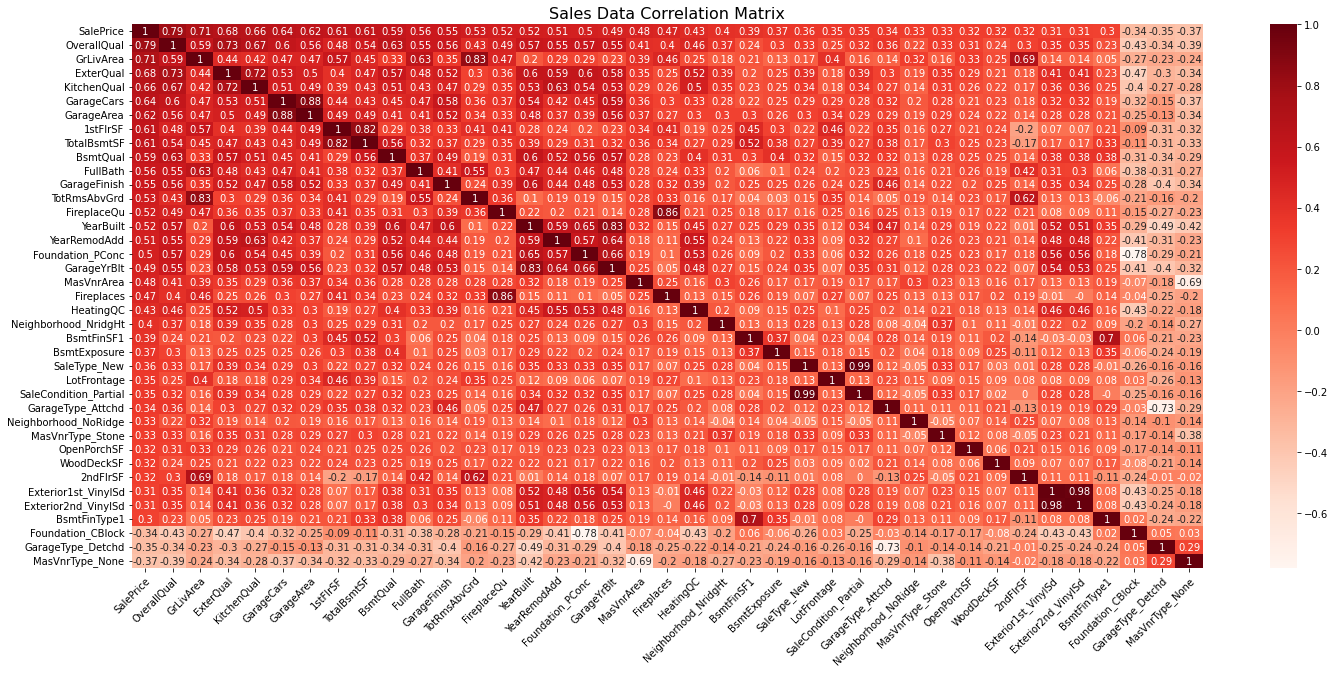

In [21]:
corr = round(train_processed.drop(columns = ['Id']).corr(), 2)
select = list(corr[(corr['SalePrice'] >= .3) | (corr['SalePrice'] <= -.3)]['SalePrice'].sort_values(ascending = False).index)
# select = list(corr[(corr['SalePrice'] >= .3)]['SalePrice'].sort_values(ascending = False).index)

train_select = train_processed[select]

corr2 = round(train_select.corr(), 2)

# # Plot correlation matrix
fig, ax = plt.subplots(figsize= (24,10))
sns.heatmap(corr2, cmap = 'Reds', annot = True, ax = ax)
plt.title('Sales Data Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

In [22]:
# Define Target/Feature Matrix. Train Test Split
X = train_select.drop(columns = 'SalePrice')
y = train_select['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 53)

In [23]:
# Fit to the Processor
X_train = processor.fit_transform(X_train)
X_test = processor.transform(X_test)

In [24]:
input_shape = X_train.shape[1]
input_shape

25

Epoch 1/250
35/35 [==============================] - 1s 8ms/step - loss: 38514642944.0000 - mse: 38514642944.0000 - val_loss: 40610959360.0000 - val_mse: 40610959360.0000
Epoch 2/250
35/35 [==============================] - 0s 3ms/step - loss: 38513389568.0000 - mse: 38513389568.0000 - val_loss: 40608735232.0000 - val_mse: 40608735232.0000
Epoch 3/250
35/35 [==============================] - 0s 3ms/step - loss: 38509207552.0000 - mse: 38509207552.0000 - val_loss: 40601407488.0000 - val_mse: 40601407488.0000
Epoch 4/250
35/35 [==============================] - 0s 3ms/step - loss: 38497181696.0000 - mse: 38497181696.0000 - val_loss: 40581763072.0000 - val_mse: 40581763072.0000
Epoch 5/250
35/35 [==============================] - 0s 6ms/step - loss: 38467563520.0000 - mse: 38467563520.0000 - val_loss: 40538251264.0000 - val_mse: 40538251264.0000
Epoch 6/250
35/35 [==============================] - 0s 3ms/step - loss: 38407335936.0000 - mse: 38407335936.0000 - val_loss: 40452161536.0000 - 

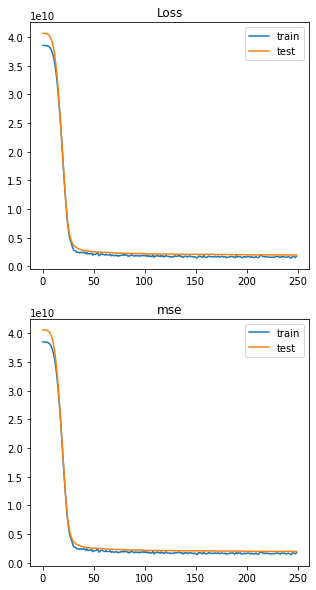

None

Training rmse: 25959.022
Testing rmse: 44265.597

Training R2: 0.884
Test R2: 0.746


In [25]:
# Overfit model without dropout
model3 = Sequential()

# First Hidden Layer
model3.add(Dense(25, input_dim = input_shape, activation = 'relu')) 
model3.add(Dropout(.1)) 
          
# Second Hidden Layer
model3.add(Dense(25, activation = 'relu'))
model3.add(Dropout(.1)) 

# Third Hidden Layer
model3.add(Dense(15, activation = 'relu'))
model3.add(Dropout(.1)) 

# Output Layer
model3.add(Dense(1, activation = 'relu'))

# Compile the model
model3.compile(optimizer = 'adam', loss = 'mse', metrics = 'mse')

# early_stopping = EarlyStopping(patience = 8)

# Fit the model
history = model3.fit(X_train, y_train, validation_data = (X_test, y_test),
                    epochs=250)#, callbacks = [early_stopping])

display(plot_history(history, 'mse'))

train_preds = model3.predict(X_train)
test_preds = model3.predict(X_test)

print(f'Training rmse: {np.sqrt(mean_squared_error(y_train, train_preds)):.3f}')
print(f'Testing rmse: {np.sqrt(mean_squared_error(y_test, test_preds)):.3f}')

print(f'\nTraining R2: {r2_score(y_train, train_preds):.3f}')
print(f'Test R2: {r2_score(y_test, test_preds):.3f}')

### Results
Second Feature selected model does not appear to perform better than the initial model.

- Top Training RMSE: ~43.5k
- Top R2: ~ 0.755

# Test Dataset - New Predictions

In [26]:
# Load Testing Data
test = pd.read_csv(test_path)
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [27]:
# Same preprocessing as above
for col in ord_cols:
    test[col] = test[col].map(ord_map)
    test[col].fillna(value = 0, inplace = True)
    test[col] = test[col].astype(int)

for col in na_list:
    test[col].fillna(value = f'no {col}', inplace = True)

test['CentralAir'] = test['CentralAir'].map({'N':0, 'Y':1})

In [28]:
# Fit final model to Train, Transform to Test
X = train.drop(columns = 'SalePrice')
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 53)

processor.fit_transform(X_train)
to_model = processor.transform(test)

In [29]:
# Get Preds from Model
preds = model.predict(to_model)
preds

array([[ 98962.98 ],
       [152087.69 ],
       [156974.23 ],
       ...,
       [164743.2  ],
       [ 97226.516],
       [233685.47 ]], dtype=float32)

In [30]:
# to_submit = pd.DataFrame({'Id': test['Id'], 'SalePrice': preds})
to_submit = pd.DataFrame(preds, columns = ['SalePrice'])
to_submit = pd.concat([test['Id'], to_submit], axis = 1)
to_submit.head()


,Id,SalePrice
0,1461,98962.976562
1,1462,152087.687500
2,1463,156974.234375
3,1464,178561.734375
4,1465,178401.437500


In [31]:
to_submit.to_csv('/content/drive/MyDrive/Data/kaggle/ames_submission.csv', index = False)

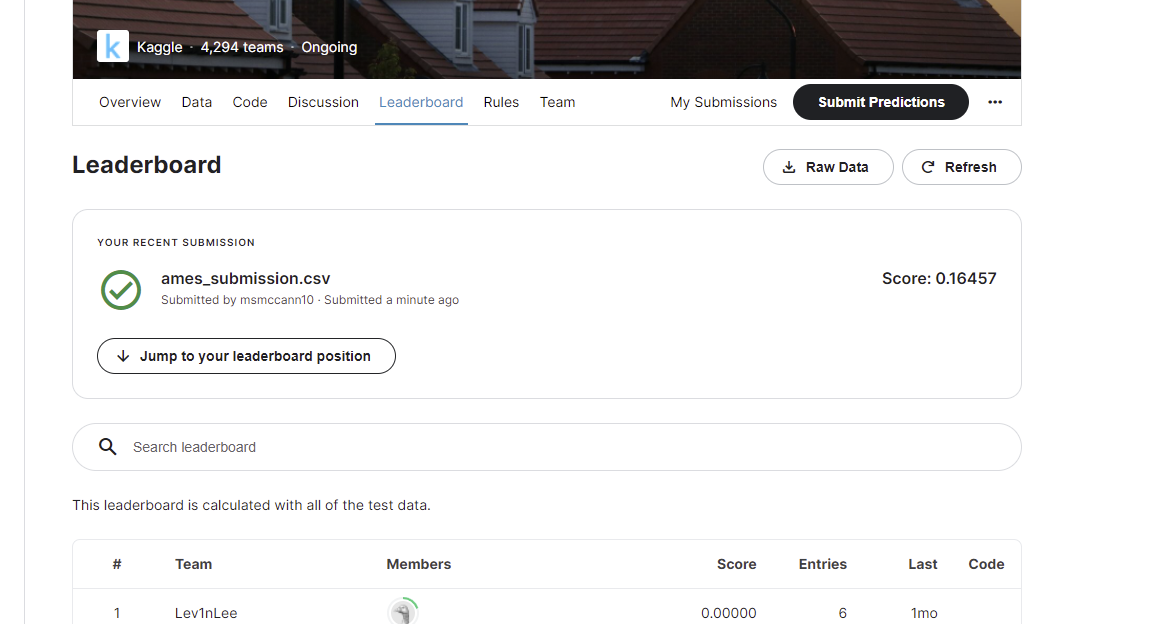